In [1]:
import os
data_path = os.path.join('/project','data','object','fire')
train_data_path = os.path.join(data_path,'train')
valid_data_path = os.path.join(data_path,'test')
CATEGORIES = ['Fire', 'NoFire']
batch_size = 10
thread_accuracy = 0.95
thread_loss = 0.01

# 准备数据

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import lib.ob_dataset as dataset
import importlib
importlib.reload(dataset)

IMG_SIZE = 64

def create_training_data(data_dir, categories):
    training_data = []
    for item in categories:  

        path = os.path.join(data_dir,item) 
        class_num = categories.index(item)  # get the classification  (0 or a 1). 0=C 1=O

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return training_data

train_data = create_training_data(train_data_path,CATEGORIES)
train_dataset = dataset.ObjectDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=dataset.collate)

valid_data = create_training_data(valid_data_path,CATEGORIES)
valid_dataset = dataset.ObjectDataset(valid_data)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=True,collate_fn=dataset.collate)

# for idx, (image, label) in enumerate(train_dataset):
#     print(idx, '--->', label, '-->', image.shape)

# for step, values in enumerate(train_loader):
#     images = values[0]
#     labels = values[1]
#     print('{}, image size {} labels size{}'.format(step, images.size(), labels))
print('over')


100%|██████████| 294/294 [00:05<00:00, 50.80it/s]

over


# 模型

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FireModule(nn.Module):
    '''
    imgH 
    nc  img channel
    '''
    def __init__(self, imgH, nc,nclass=2):
        super(FireModule,self).__init__()
        ks = [3, 3, 3]
        ps = [1, 1, 1]
        ss = [1, 1, 1]
        nm = [64, 128, 256]
        
        cnn = nn.Sequential()
        def convRelu(i, batchNormalization=False, leakyRelu=False, dropout=True):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if dropout:
                cnn.add_module('dropout{0}'.format(i),nn.Dropout(0.5))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))    

                
        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.AvgPool2d(4, 4))  # 64x16*16
        convRelu(1,dropout=True)
        cnn.add_module('pooling{0}'.format(1), nn.AvgPool2d(4, 4))  # 128x4*4
        convRelu(2,batchNormalization=True,dropout=False)
        cnn.add_module('pooling{0}'.format(2), nn.AvgPool2d(4, 4))  # 256*1*1
        self.cnn = cnn
        self.fc_1 = nn.Linear(256, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, nclass)
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input):
        output = self.cnn(input)
        output = output.view(output.size(0),-1)
        output = self.fc_1(output)
        output = self.dropout(output)
        output = self.activate(output)
        output = self.fc_2(output)
        output = self.activate(output)
        output = self.fc_3(output)
        return output

# 训练

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time

if torch.cuda.is_available():
#     net.cuda()
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    print("Using GPU")
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    print("No GPU detected")
    

def valid_net(net, valid_dataset):
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=True,collate_fn=dataset.collate)
    i = 0
    n_correct = 0    
    net.eval()
    with torch.no_grad():
        for step, values in enumerate(valid_loader):
            images = Variable(values[0].type(dtype),requires_grad=False)
            targets = values[1]
            preds = net(images).cpu()
#             print(preds.size())
            _, preds = preds.max(1)
            preds = preds.view(-1)
            for pred, target in zip(preds, targets):
                if pred == target:
                    n_correct += 1    
#     print('preds -->{}'.format(preds))
#     print('target -->{}'.format(targets))
    accuracy = n_correct / float(len(valid_dataset))
    return accuracy, n_correct

    
net = FireModule(imgH=64, nc=3)
net.load_state_dict(torch.load('{}/fire_best.pkh'.format('/project'),map_location=torch.device('cpu')))
if torch.cuda.is_available():
    net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4,betas=(0.1, 0.999))
criterion = nn.CrossEntropyLoss()

current_accuracy = 0.0

for epoch in range(1000):
    start_time = time.time()
    total_loss = 0
    net.train()
    for step, values in enumerate(train_loader):
        images = Variable(values[0].type(dtype),requires_grad=False)
        targets = torch.LongTensor(np.array(values[1]))
        targets = Variable(targets.type(ltype),requires_grad=False )
        preds= net(images)
        loss = criterion(preds, targets)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    total_loss = total_loss/(step+1)
    accuracy, num_correct = valid_net(net,valid_dataset)
    if accuracy > current_accuracy:
        current_accuracy = accuracy
        torch.save(net.state_dict(),'{}/save/fire_{}.pkl'.format('/project',epoch))    
    if accuracy >= 0.9 and total_loss<=thread_loss:
        torch.save(net.state_dict(),'{}/save/fire_{}.pkl'.format('/project',epoch))    
    if accuracy >= thread_accuracy and total_loss<=thread_loss:
        print('traing over ....')
        break
        
    print('epcho{}  loss -->{} accuracy -->{} correct -->{} time {}'.format(epoch, total_loss,accuracy, 
                                                                            num_correct, (time.time() - start_time)))
    

Using GPU
epcho0  loss -->0.01785886473953724 accuracy -->0.7531003382187148 correct -->668 time 1.2447762489318848
epcho1  loss -->0.03551076725125313 accuracy -->0.9571589627959414 correct -->849 time 1.2349891662597656
epcho2  loss -->0.007409603334963322 accuracy -->0.677564825253664 correct -->601 time 1.2302699089050293
epcho3  loss -->0.007351797539740801 accuracy -->0.90304396843292 correct -->801 time 1.2341983318328857
epcho4  loss -->0.007303439546376467 accuracy -->0.943630214205186 correct -->837 time 1.2378888130187988
epcho5  loss -->0.02008976973593235 accuracy -->0.8511837655016911 correct -->755 time 1.2315175533294678
epcho6  loss -->0.005470086820423603 accuracy -->0.4926719278466742 correct -->437 time 1.2454512119293213
epcho7  loss -->0.01925589144229889 accuracy -->0.9244644870349493 correct -->820 time 1.2419497966766357
epcho8  loss -->0.020690644159913063 accuracy -->0.9402480270574972 correct -->834 time 1.2381184101104736
epcho9  loss -->0.00519195385277271

# 验证

Using GPU


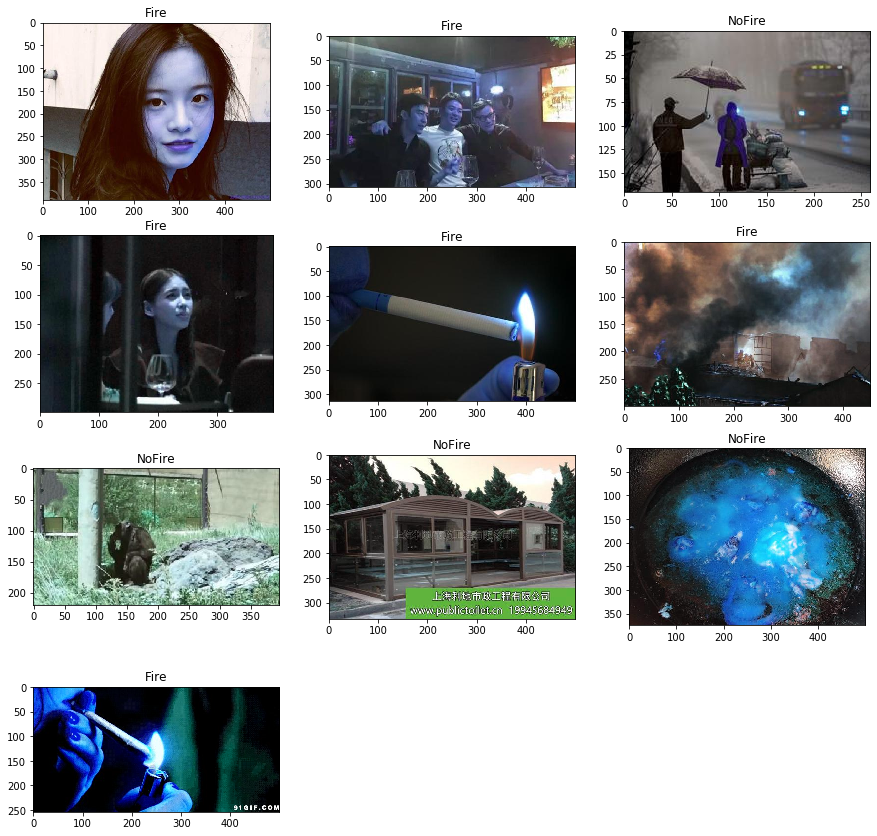

In [8]:
import torch
import torch.nn as nn
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import lib.video.fire_detect as fire_detect 
import importlib
importlib.reload(fire_detect)
plt.rcParams['figure.figsize'] = 15, 15

module_path = '{}/fire_best.pkh'.format('/project')
detect = fire_detect.FireDetect(module_path=module_path)
check_path = os.path.join('/project','data', 'test','object','fire')

check_files = []
for root, dirs, files in os.walk(check_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            check_files.append(os.path.join(root, file))
random.shuffle(check_files)
check_files = check_files[0:10]
rownum = int(len(check_files)/ 3) + 1
colnum = 3
plt.figure()

for idx, imgfile in enumerate(check_files):
#     print(imgfile)
    image_source = cv2.imread(imgfile, cv2.IMREAD_COLOR)
    pred = detect.detect(image_source)
    flag = CATEGORIES[pred]
    plt.subplot(rownum,colnum,idx+1)
    plt.title('{}'.format(flag))
    plt.imshow(image_source,'brg')

Using GPU


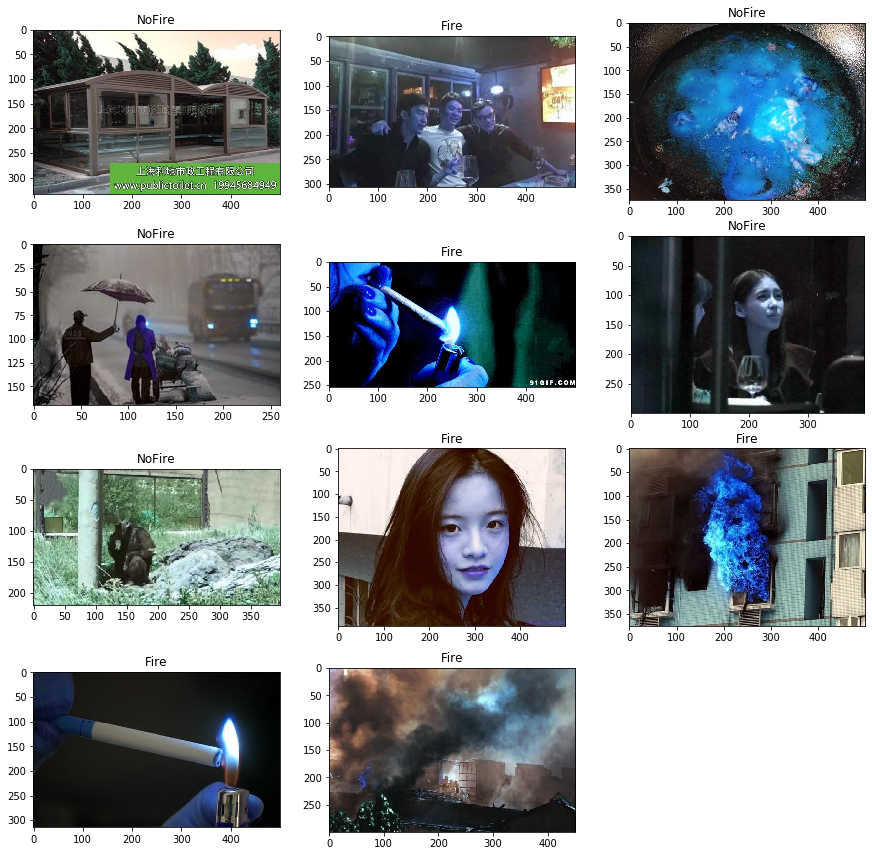

In [167]:
import torch
import torch.nn as nn
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
plt.rcParams['figure.figsize'] = 15, 15

net =  FireModule(imgH=64, nc=3)
net.load_state_dict(torch.load('{}/fire_best.pkh'.format('/project'),map_location=torch.device('cpu')))

if torch.cuda.is_available():
    net.cuda()
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    print("Using GPU")
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    print("No GPU detected")

    

to_tensor = transforms.ToTensor()




check_path = os.path.join('/project','data', 'test','object','fire')

check_files = []
for root, dirs, files in os.walk(check_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            check_files.append(os.path.join(root, file))
random.shuffle(check_files)

rownum = int(len(check_files)/ 3) + 1
colnum = 3
plt.figure()
net.eval()

for idx, imgfile in enumerate(check_files):
#     print(imgfile)
    image_source = cv2.imread(imgfile, cv2.IMREAD_COLOR)
    image = cv2.resize(image_source.copy(), (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
    image = image.astype(np.float32)
    image = image/255.0
    image = to_tensor(image)
    image.unsqueeze_(0)
    image = Variable(image.type(dtype),requires_grad=False)
    with torch.no_grad():
        preds = net(image).cpu()
        _, pred = preds.max(1)
    flag = CATEGORIES[pred.item()]
    plt.subplot(rownum,colnum,idx+1)
    plt.title('{}'.format(flag))
    plt.imshow(image_source,'brg')
    